References:
- https://machinelearningmastery.com/building-transformer-models-with-attention-crash-course-build-a-neural-machine-translator-in-12-days/

In [1]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

SEED = 42

2.12.0
1.22.4


## 1. Obtaining Data

As you are building a neural machine translator, you need data for training and testing. Let’s build a sentence-based English-to-French translator. There are many resources on the Internet. An example would be the user-contributed data for the flash card app Anki. You can download some data files at https://ankiweb.net/shared/decks/french. The data file would be a ZIP file containing a SQLite database file, from which you can extract the English-French sentence pairs.

However, you may find it more convenient to have a text file version, which you can find it at https://www.manythings.org/anki/. Google hosts a mirror of this file as
well, which we will be using.

The code below will download the compressed data file and extract it:

In [2]:
import pathlib
 
import tensorflow as tf
 
# download dataset provided by Anki: https://www.manythings.org/anki/
text_file = tf.keras.utils.get_file(
    fname="fra-eng.zip",
    origin="http://storage.googleapis.com/download.tensorflow.org/data/fra-eng.zip",
    extract=True,
)
# show where the file is located now
text_file = pathlib.Path(text_file).parent / "fra.txt"
print(text_file)

3423204/3423204 [==============================] - 1s 0us/step
/root/.keras/datasets/fra.txt


## 2. Text Normalization

Just like all NLP tasks, you need to normalize the text before you use it. French letters have accents which would be represented as Unicode characters, but such representation is not unique in Unicode. Therefore, you will convert the string into NFKC (compatibility and composition normal form).

Next, you will tokenize the sentences. Each word should be a separate token as well as each punctuation mark. However, the punctuation used in contractions such as don’t, va-t-il, or c’est are not separated from the words. Also, convert everything into lowercase in the expectation that this will reduce the number of distinct words in the vocabulary.

Normalization and tokenization can go a lot deeper, such as subword tokenization, stemming, and lemmatization. But to keep things simple, you do not do these in this project.

Starting from scratch, the code to normalize the text is below. You will use the Python module unicodedata to convert a Unicode string into NFKC normal form. Then you will use regular expression to add space around punctuation marks. Afterward, you will wrap the French sentences (i.e., the target language) with sentinels [start] and [end]. You will see the purpose of the sentinels in later lessons.

In [3]:
import pathlib
import pickle
import re
import unicodedata
import random
random.seed(SEED)

import tensorflow as tf
 
# download dataset provided by Anki: https://www.manythings.org/anki/
text_file = tf.keras.utils.get_file(
    fname="fra-eng.zip",
    origin="http://storage.googleapis.com/download.tensorflow.org/data/fra-eng.zip",
    extract=True,
)
text_file = pathlib.Path(text_file).parent / "fra.txt"
 
def normalize(line):
    """Normalize a line of text and split into two at the tab character"""
    line = unicodedata.normalize("NFKC", line.strip().lower())
    line = re.sub(r"^([^ \w])(?!\s)", r"\1 ", line)
    line = re.sub(r"(\s[^ \w])(?!\s)", r"\1 ", line)
    line = re.sub(r"(?!\s)([^ \w])$", r" \1", line)
    line = re.sub(r"(?!\s)([^ \w]\s)", r" \1", line)
    eng, fra = line.split("\t")
    fra = "[start] " + fra + " [end]"
    return eng, fra
 
# normalize each line and separate into English and French
with open(text_file) as fp:
    text_pairs = [normalize(line) for line in fp]
 
# print some samples
for _ in range(5):
    print(random.choice(text_pairs))
 
with open("text_pairs.pickle", "wb") as fp:
    pickle.dump(text_pairs, fp)

('is anybody in there ?', '[start] y a-t-il qui que ce soit , là-dedans  ?  [end]')
('we all agreed .', "[start] nous sommes tous tombés d'accord . [end]")
("i didn't catch the meaning .", "[start] je n'ai pas compris ce que ça signifiait . [end]")
('he goes to school on foot .', "[start] il marche vers l'école . [end]")
("i don't have any sisters .", "[start] je n'ai pas de sœurs . [end]")


We saved the normalized sentence pairs in a pickle file, so we can reuse it in subsequent steps.

When you use it for your model, you want to know some statistics about this dataset. In particular, you want to see how many distinct tokens (words) in each language and how long the sentences are. You can figure these out as follows:

In [4]:
import pickle
 
with open("text_pairs.pickle", "rb") as fp:
    text_pairs = pickle.load(fp)
 
# count tokens
eng_tokens, fra_tokens = set(), set()
eng_maxlen, fra_maxlen = 0, 0

for eng, fra in text_pairs:
    eng_tok, fra_tok = eng.split(), fra.split()
    eng_maxlen = max(eng_maxlen, len(eng_tok))
    fra_maxlen = max(fra_maxlen, len(fra_tok))
    eng_tokens.update(eng_tok)
    fra_tokens.update(fra_tok)
    
print(f"Total English tokens: {len(eng_tokens)}")
print(f"Total French tokens: {len(fra_tokens)}")
print(f"Max English length: {eng_maxlen}")
print(f"Max French length: {fra_maxlen}")
print(f"{len(text_pairs)} total pairs")

Total English tokens: 14969
Total French tokens: 29219
Max English length: 51
Max French length: 60
167130 total pairs


### Task

Run the above code. See not only the sample sentences but also the statistics you collected. Remember the output as they will be useful for your next lesson. Besides, knowing the maximum length of sentences is not as useful as knowing their distribution. You should plot a histogram for that. Try out this to produce the following chart:

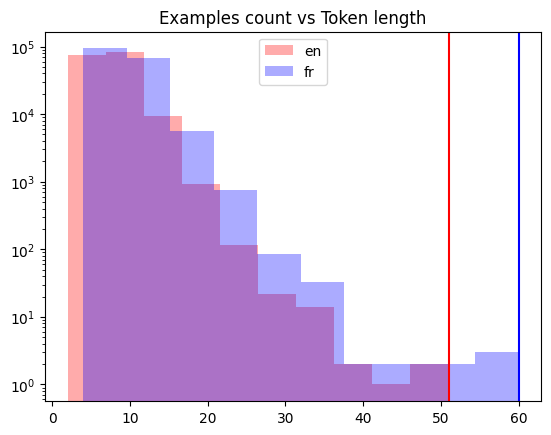

In [5]:
import pickle
 
import matplotlib.pyplot as plt
 
with open("text_pairs.pickle", "rb") as fp:
    text_pairs = pickle.load(fp)
 
# histogram of sentence length in tokens
en_lengths = [len(eng.split()) for eng, fra in text_pairs]
fr_lengths = [len(fra.split()) for eng, fra in text_pairs]
 
plt.hist(en_lengths, label="en", color="red", alpha=0.33)
plt.hist(fr_lengths, label="fr", color="blue", alpha=0.33)
plt.yscale("log")     # sentence length fits Benford"s law
plt.ylim(plt.ylim())  # make y-axis consistent for both plots
plt.plot([max(en_lengths), max(en_lengths)], plt.ylim(), color="red")
plt.plot([max(fr_lengths), max(fr_lengths)], plt.ylim(), color="blue")
plt.legend()
plt.title("Examples count vs Token length")
plt.show()

## 3. Vectorization and Making Datasets

In the previous lesson, you cleaned up the sentences, but they are still text. Neural networks can handle only numbers. One way to convert the text into numbers is through vectorization. What this means is to transform the tokens from the text into an integer. Hence a sentence with 
 tokens (words) will become a vector of 
 integers.

You can build your own vectorizer. Simply build a mapping table of each unique token to a unique integer. When it is used, you look up the token one by one in the table and return the integers in the form of a vector.

In Keras, you have TextVectorization layer to save us the effort of building a vectorizer. It supports padding, i.e., integer 0 is reserved to mean “empty.” This is useful when you give a sentence of 
 tokens but want the vectorizer always to return a fixed length 
 vector.

You will first split the sentence pair into training, validation, and testing sets as you need them for the model training. Then, create a TextVectorization layer and adapt it to the training set only (because you should not peek into the validation or testing dataset until the model training is completed).

In [6]:
import pickle
import random
random.seed(SEED)

from tensorflow.keras.layers import TextVectorization
 
# Load normalized sentence pairs
with open("text_pairs.pickle", "rb") as fp:
    text_pairs = pickle.load(fp)
 
# train-test-val split of randomized sentence pairs
random.shuffle(text_pairs)
n_val = int(0.15*len(text_pairs))
n_train = len(text_pairs) - 2*n_val
train_pairs = text_pairs[:n_train]
val_pairs = text_pairs[n_train:n_train+n_val]
test_pairs = text_pairs[n_train+n_val:]
 
# Parameter determined after analyzing the input data
vocab_size_en = 10000
vocab_size_fr = 20000
seq_length = 20
 
# Create vectorizer
eng_vectorizer = TextVectorization(
    max_tokens=vocab_size_en,
    standardize=None,
    split="whitespace",
    output_mode="int",
    output_sequence_length=seq_length,
)
fra_vectorizer = TextVectorization(
    max_tokens=vocab_size_fr,
    standardize=None,
    split="whitespace",
    output_mode="int",
    output_sequence_length=seq_length + 1
)
 
# train the vectorization layer using training dataset
train_eng_texts = [pair[0] for pair in train_pairs]
train_fra_texts = [pair[1] for pair in train_pairs]
eng_vectorizer.adapt(train_eng_texts)
fra_vectorizer.adapt(train_fra_texts)
 
# save for subsequent steps
with open("vectorize.pickle", "wb") as fp:
    data = {
        "train": train_pairs,
        "val":   val_pairs,
        "test":  test_pairs,
        "engvec_config":  eng_vectorizer.get_config(),
        "engvec_weights": eng_vectorizer.get_weights(),
        "fravec_config":  fra_vectorizer.get_config(),
        "fravec_weights": fra_vectorizer.get_weights(),
    }
    pickle.dump(data, fp)

Note that the parameter max_tokens to TextVectorization object can be omitted to let the vectorizer figure it out. But if you set them to a value smaller than the total vocabulary (such as this case), you limit the the vectorizer to learn only the more frequent words and make the rare words as out-of-vocabulary (OOV). This may be useful to skip the words of little value or with spelling mistakes. You also fix the output length of the vectorizer. We assumed that a sentence should have no more than 20 tokens in the above.

### Task

The next step would be to make use of the vectorizer and create a TensorFlow Dataset object. This will be helpful in your later steps to train our model.

In [7]:
import pickle
 
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
 
# load text data and vectorizer weights
with open("vectorize.pickle", "rb") as fp:
    data = pickle.load(fp)
 
train_pairs = data["train"]
val_pairs = data["val"]
test_pairs = data["test"]   # not used
 
eng_vectorizer = TextVectorization.from_config(data["engvec_config"])
eng_vectorizer.set_weights(data["engvec_weights"])
fra_vectorizer = TextVectorization.from_config(data["fravec_config"])
fra_vectorizer.set_weights(data["fravec_weights"])
 
# set up Dataset object
def format_dataset(eng, fra):
    """Take an English and a French sentence pair, convert into input and target.
    The input is a dict with keys `encoder_inputs` and `decoder_inputs`, each
    is a vector, corresponding to English and French sentences respectively.
    The target is also vector of the French sentence, advanced by 1 token. All
    vector are in the same length.
 
    The output will be used for training the transformer model. In the model we
    will create, the input tensors are named `encoder_inputs` and `decoder_inputs`
    which should be matched to the keys in the dictionary for the source part
    """
    eng = eng_vectorizer(eng)
    fra = fra_vectorizer(fra)
    source = {"encoder_inputs": eng,
              "decoder_inputs": fra[:, :-1]}
    target = fra[:, 1:]
    return (source, target)
 
def make_dataset(pairs, batch_size=64):
    """Create TensorFlow Dataset for the sentence pairs"""
    # aggregate sentences using zip(*pairs)
    eng_texts, fra_texts = zip(*pairs)
    # convert them into list, and then create tensors
    dataset = tf.data.Dataset.from_tensor_slices((list(eng_texts), list(fra_texts)))
    return dataset.shuffle(2048) \
                  .batch(batch_size).map(format_dataset) \
                  .prefetch(16).cache()
 
train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)
 
# test the dataset
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["encoder_inputs"][0]: {inputs["encoder_inputs"][0]}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"][0]: {inputs["decoder_inputs"][0]}')
    print(f"targets.shape: {targets.shape}")
    print(f"targets[0]: {targets[0]}")

inputs["encoder_inputs"].shape: (64, 20)
inputs["encoder_inputs"][0]: [302 130  61 698  17   6 127 408   2   0   0   0   0   0   0   0   0   0
   0   0]
inputs["decoder_inputs"].shape: (64, 20)
inputs["decoder_inputs"][0]: [   2   15   53   21  100    6  413 4656   36  198  878    4    3    0
    0    0    0    0    0    0]
targets.shape: (64, 20)
targets[0]: [  15   53   21  100    6  413 4656   36  198  878    4    3    0    0
    0    0    0    0    0    0]


You will reuse this code later to make the train_ds and val_ds dataset objects.

The exact vector may not be the same, but you should see that the shape should all be (batch size, sequence length). Some code above is borrowed from the tutorial by François Chollet, English-to-Spanish translation with a sequence-to-sequence Transformer. You may also want to see how his implementation of transformer is different from this mini-course.

In the next lesson, you will move to the topic of position encoding.

## 4. Positional Encoding Matrix

When a sentence is vectorized, you get a vector of integers, where each integer represents a word. The integer here is only a label. We cannot assume two integers closer to each other means the words they represent are related.

In order to understand the meaning of words and hence quantify how two words are related to each other, you will use the technique word embeddings. But to understand the context, you also need to know the position of each word in a sentence. This is done by positional encoding.

In the paper Attention Is All You Need, positional encoding represents each token position with a vector. The elements of the vector are values of the different phase and frequency of sine waves. Precisely, at position 
, the positional encoding vector (of length 
) is


where for 
,

 
 
 

In the paper, they used 
.

Implementing the positional encoding is not difficult, especially if you can use vector functions from NumPy.

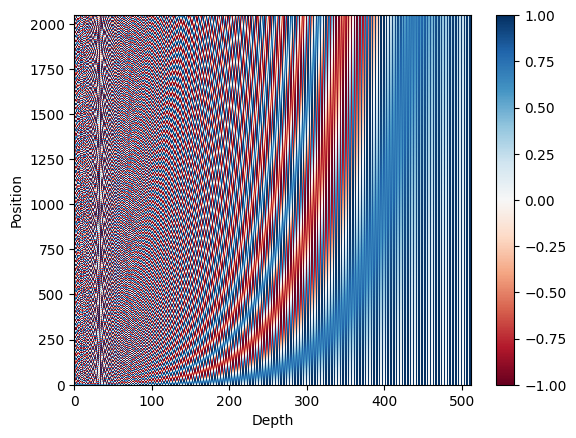

In [8]:
import pickle
 
import matplotlib.pyplot as plt
import numpy as np
 
 
def pos_enc_matrix(L, d, n=10000):
    """Create positional encoding matrix
 
    Args:
        L: Input dimension (length)
        d: Output dimension (depth), even only
        n: Constant for the sinusoidal functions
 
    Returns:
        numpy matrix of floats of dimension L-by-d. At element (k,2i) the value
        is sin(k/n^(2i/d)) while at element (k,2i+1) the value is cos(k/n^(2i/d))
    """
    assert d % 2 == 0, "Output dimension needs to be an even integer"
    d2 = d//2
    P = np.zeros((L, d))
    k = np.arange(L).reshape(-1, 1)     # L-column vector
    i = np.arange(d2).reshape(1, -1)    # d-row vector
    denom = np.power(n, -i/d2)          # n**(-2*i/d)
    args = k * denom                    # (L,d) matrix
    P[:, ::2] = np.sin(args)
    P[:, 1::2] = np.cos(args)
    return P
 
 
# Plot the positional encoding matrix
pos_matrix = pos_enc_matrix(L=2048, d=512)
assert pos_matrix.shape == (2048, 512)
plt.pcolormesh(pos_matrix, cmap='RdBu')
plt.xlabel('Depth')
plt.ylabel('Position')
plt.colorbar()
plt.show()
 
with open("posenc-2048-512.pickle", "wb") as fp:
    pickle.dump(pos_matrix, fp)

You can see that we created a function to generate the positional encoding. We tested it out with 
 and 
 above. The output would be a 
 matrix. We also plot the encoding in a heatmap. This should look like the following.

### Task

The heatmap above may not be very appealing to you. A better way to visualize it is to separate the sine curves from the cosine curves. Try out the code below to reuse the pickled positional encoding matrix and obtain a clearer visualization:

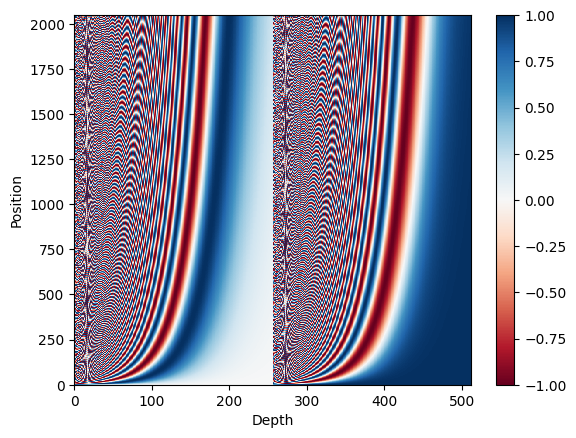

In [9]:
import pickle
 
import matplotlib.pyplot as plt
import numpy as np
 
with open("posenc-2048-512.pickle", "rb") as fp:
    pos_matrix = pickle.load(fp)
assert pos_matrix.shape == (2048, 512)

# Plot the positional encoding matrix, alternative way
plt.pcolormesh(np.hstack([pos_matrix[:, ::2], pos_matrix[:, 1::2]]), cmap='RdBu')
plt.xlabel('Depth')
plt.ylabel('Position')
plt.colorbar()
plt.show()

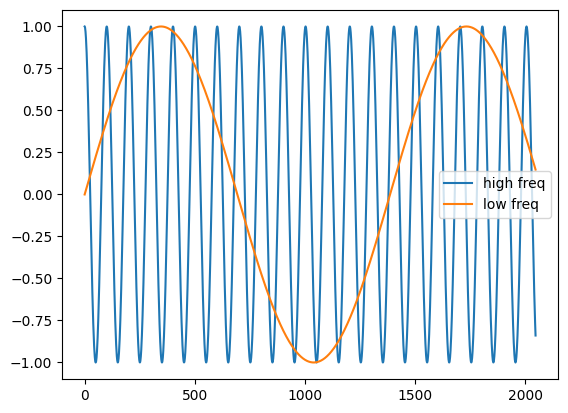

In [10]:
plt.plot(pos_matrix[:, 155], label="high freq")
plt.plot(pos_matrix[:, 300], label="low freq")
plt.legend()
plt.show()

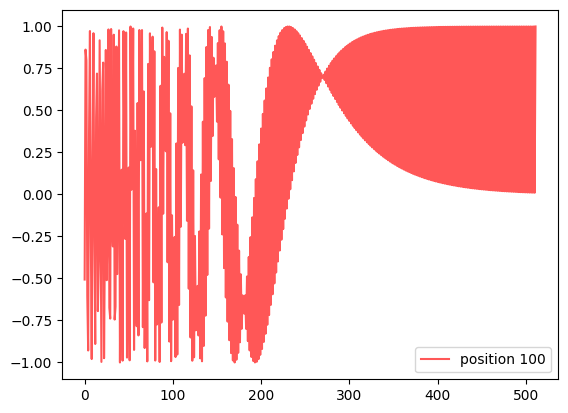

In [11]:
import pickle
import matplotlib.pyplot as plt
 
with open("posenc-2048-512.pickle", "rb") as fp:
    pos_matrix = pickle.load(fp)
assert pos_matrix.shape == (2048, 512)
# Plot two curves from different position
plt.plot(pos_matrix[100], alpha=0.66, color="red", label="position 100")
plt.legend()
plt.show()

The encoding matrix is useful in the sense that, when you compare two encoding vectors, you can tell how far apart their positions are. The dot-product of two normalized vectors is 1 if they are identical and drops quickly as they move apart. This relationship can be visualized below:



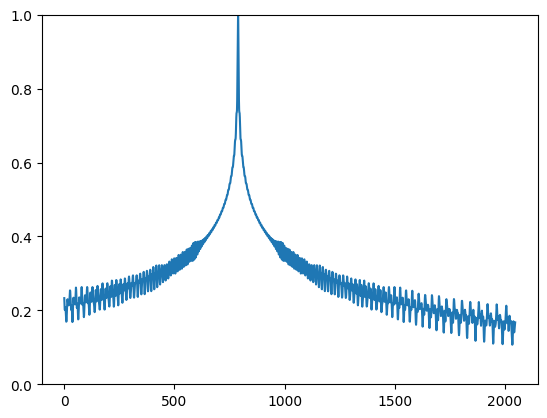

In [12]:
import pickle
 
import matplotlib.pyplot as plt
import numpy as np
 
 
with open("posenc-2048-512.pickle", "rb") as fp:
    pos_matrix = pickle.load(fp)
assert pos_matrix.shape == (2048, 512)
# Show the dot product between different normalized positional vectors
pos_matrix /= np.linalg.norm(pos_matrix, axis=1, keepdims=True)
p = pos_matrix[789]  # all vectors compare to vector at position 789
dots = pos_matrix @ p
plt.plot(dots)
plt.ylim([0, 1])
plt.show()

In the next lesson, you will make use of the positional encoding matrix to build a positional encoding layer in Keras.

## 5. Positional Encoding Layer

The transformer model from the paper Attention Is All You Need is illustrated below:

The positional encoding layer is at the entry point of a transformer model. However, the Keras library does not provide us one. You can create a custom layer to implement the positional encoding, as follows.

In [13]:
import numpy as np
import tensorflow as tf
 
def pos_enc_matrix(L, d, n=10000):
    """Create positional encoding matrix
 
    Args:
        L: Input dimension (length)
        d: Output dimension (depth), even only
        n: Constant for the sinusoidal functions
 
    Returns:
        numpy matrix of floats of dimension L-by-d. At element (k,2i) the value
        is sin(k/n^(2i/d)) while at element (k,2i+1) the value is cos(k/n^(2i/d))
    """
    assert d % 2 == 0, "Output dimension needs to be an even integer"
    d2 = d//2
    P = np.zeros((L, d))
    k = np.arange(L).reshape(-1, 1)     # L-column vector
    i = np.arange(d2).reshape(1, -1)    # d-row vector
    denom = np.power(n, -i/d2)          # n**(-2*i/d)
    args = k * denom                    # (L,d) matrix
    P[:, ::2] = np.sin(args)
    P[:, 1::2] = np.cos(args)
    return P
 
class PositionalEmbedding(tf.keras.layers.Layer):
    """Positional embedding layer. Assume tokenized input, transform into
    embedding and returns positional-encoded output."""
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        """
        Args:
            sequence_length: Input sequence length
            vocab_size: Input vocab size, for setting up embedding matrix
            embed_dim: Embedding vector size, for setting up embedding matrix
        """
        super().__init__(**kwargs)
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim     # d_model in paper
        # token embedding layer: Convert integer token to D-dim float vector
        self.token_embeddings = tf.keras.layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim, mask_zero=True
        )
        # positional embedding layer: a matrix of hard-coded sine values
        matrix = pos_enc_matrix(sequence_length, embed_dim)
        self.position_embeddings = tf.constant(matrix, dtype="float32")
 
    def call(self, inputs):
        """Input tokens convert into embedding vectors then superimposed
        with position vectors"""
        embedded_tokens = self.token_embeddings(inputs)
        return embedded_tokens + self.position_embeddings
 
    # this layer is using an Embedding layer, which can take a mask
    # see https://www.tensorflow.org/guide/keras/masking_and_padding#passing_mask_tensors_directly_to_layers
    def compute_mask(self, *args, **kwargs):
        return self.token_embeddings.compute_mask(*args, **kwargs)
 
    def get_config(self):
        # to make save and load a model using custom layer possible
        config = super().get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
        })
        return config

This layer is indeed combining an embedding layer with position encoding. The embedding layer creates word embeddings, namely, converting an integer token label from the vectorized sentence into a vector that can carry the meaning of the word. With the embedding, you can tell how close in meaning the two different words are.

The embedding output depends on the tokenized input sentence. But the positional encoding is a constant matrix as it depends only on the position. Hence you create a constant tensor for that at the time you created this layer. TensorFlow is smart enough to match the dimensions when you add the embedding output to the positional encoding matrix, in the call() function.

Two additional functions are defined in the layer above. The compute_mask() function is passed on to the embedding layer. This is needed to tell which positions of the output are padded. This will be used internally by Keras. The get_config() function is defined to remember all the config parameters of this layer. This is a standard practice in Keras so that you remember all the parameters you passed on to the constructor and return them in get_config(), so the model can be saved and loaded.

### Task

Combine the above code together with the dataset train_ds created in Lesson 03 and the code snippet below:

In [14]:
train_ds

<CacheDataset element_spec=({'encoder_inputs': TensorSpec(shape=(None, 20), dtype=tf.int64, name=None), 'decoder_inputs': TensorSpec(shape=(None, 20), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 20), dtype=tf.int64, name=None))>

In [15]:
# From Lesson 03:
# train_ds = make_dataset(train_pairs)
 
vocab_size_en = 10000
seq_length = 20
 
# test the dataset
for inputs, targets in train_ds.take(1):
    print(inputs["encoder_inputs"])
    embed_en = PositionalEmbedding(seq_length, vocab_size_en, embed_dim=512)
    en_emb = embed_en(inputs["encoder_inputs"])
    print(en_emb.shape)
    print(en_emb._keras_mask)

tf.Tensor(
[[  32 1444   47 ...    0    0    0]
 [ 701    6  211 ...    0    0    0]
 [  20   48   50 ...    0    0    0]
 ...
 [   4   86   19 ...    0    0    0]
 [  43    6  146 ...    0    0    0]
 [   4  177   30 ...    0    0    0]], shape=(64, 20), dtype=int64)
(64, 20, 512)
tf.Tensor(
[[ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 ...
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]], shape=(64, 20), dtype=bool)


You can see that the first tensor printed above is one batch (64 samples) of the vectorized input sentences, padded with zero to length 20. Each token is an integer but will be converted into an embedding of dimension 512. Hence the shape of en_emb above is (64, 20, 512).

The last tensor printed above is the mask used. This essentially matches the input where the position is not zero. When you compute the accuracy, you have to remember the padded locations should not be counted.

In the next lesson, you will complete the other building block of the transformer model.

## 6. Transformer Building Blocks

Reviewing the diagram of transformer in Lesson 05, you will see that beyond the embedding and positional encoding, you have the encoder (left half of the figure) and decoder (right half of the figure). They share some similarities. Most notably, they have a multi-head attention block at the beginning and a feed forward block at the end.

It would be easier if you create each building block as separate submodels and later combine them into a bigger model.

First, you create the self-attention model. It is in the part of the diagram that is at the bottom of both encoder and decoder. A multi-head attention layer will take three inputs, namely, the key, the value, and the query. If all three inputs are the same, we call this multi-head attention layer self-attention. This submodel will have an add & norm layer with skip connection to normalize the output of the attention layer. Its implementation is as follows:

### Self-Attention

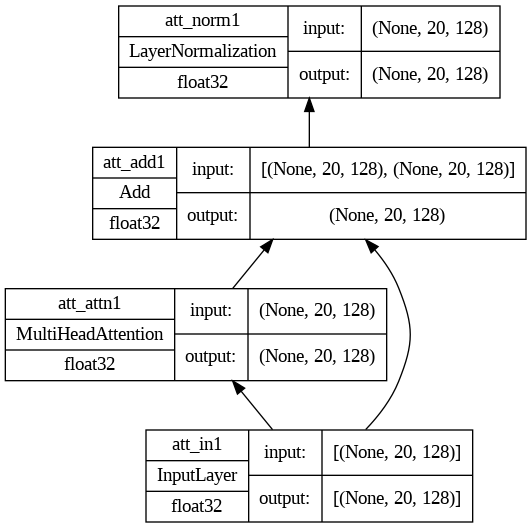

In [16]:
import tensorflow as tf
 
def self_attention(input_shape, prefix="att", mask=False, **kwargs):
    """Self-attention layers at transformer encoder and decoder. Assumes its
    input is the output from positional encoding layer.
 
    Args:
        prefix (str): The prefix added to the layer names
        masked (bool): whether to use causal mask. Should be False on encoder and
                       True on decoder. When True, a mask will be applied such that
                       each location only has access to the locations before it.
    """
    # create layers
    inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32',
                                   name=f"{prefix}_in1")
    attention = tf.keras.layers.MultiHeadAttention(name=f"{prefix}_attn1", **kwargs)
    norm = tf.keras.layers.LayerNormalization(name=f"{prefix}_norm1")
    add = tf.keras.layers.Add(name=f"{prefix}_add1")
    # functional API to connect input to output
    attout = attention(query=inputs, value=inputs, key=inputs,
                       use_causal_mask=mask)
    outputs = norm(add([inputs, attout]))
    # create model and return
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name=f"{prefix}_att")
    return model
 
seq_length = 20
key_dim = 128
num_heads = 8
 
model = self_attention(input_shape=(seq_length, key_dim),
                       num_heads=num_heads, key_dim=key_dim)
tf.keras.utils.plot_model(model, "self-attention.png",
                          show_shapes=True, show_dtype=True, show_layer_names=True,
                          rankdir='BT', show_layer_activations=True)

The function defined above is generic for both encoder and decoder. The decoder will set the option mask=True to apply causal mask to the input.

Set some parameters and create a model. The model plotted would look like the following.

In the decoder, you have a cross-attention model that takes input from the self-attention model as well as the encoder. In this case, the value and key are the output from the encoder whereas the query is the output from the self-attention model. At the high level, it is based on what the encoder understands about the context of the source sentence, and takes the partial sentence at the decoder’s input as the query (which can be empty), to predict how to complete the sentence. This is the only difference from the self-attention model; hence the code is very similar:

### Cross Attention

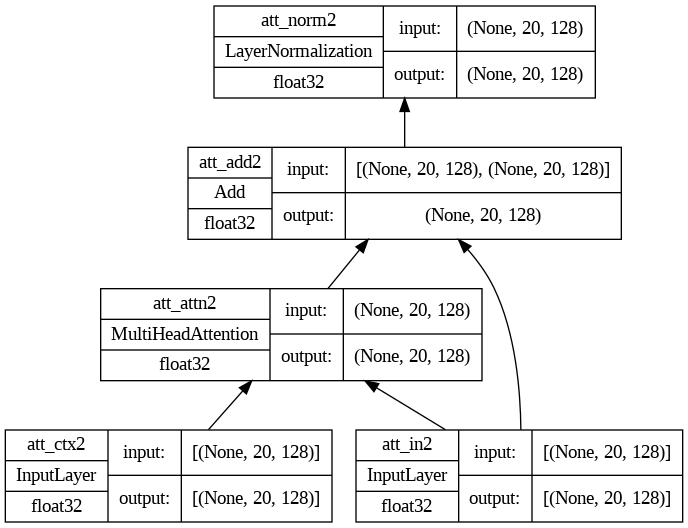

In [17]:
import tensorflow as tf
 
def cross_attention(input_shape, context_shape, prefix="att", **kwargs):
    """Cross-attention layers at transformer decoder. Assumes its
    input is the output from positional encoding layer at decoder
    and context is the final output from encoder.
 
    Args:
        prefix (str): The prefix added to the layer names
    """
    # create layers
    context = tf.keras.layers.Input(shape=context_shape, dtype='float32',
                                    name=f"{prefix}_ctx2")
    inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32',
                                   name=f"{prefix}_in2")
    attention = tf.keras.layers.MultiHeadAttention(name=f"{prefix}_attn2", **kwargs)
    norm = tf.keras.layers.LayerNormalization(name=f"{prefix}_norm2")
    add = tf.keras.layers.Add(name=f"{prefix}_add2")
    # functional API to connect input to output
    attout = attention(query=inputs, value=context, key=context)
    outputs = norm(add([attout, inputs]))
    # create model and return
    model = tf.keras.Model(inputs=[(context, inputs)], outputs=outputs,
                           name=f"{prefix}_cross")
    return model
 
seq_length = 20
key_dim = 128
num_heads = 8
 
model = cross_attention(input_shape=(seq_length, key_dim),
                        context_shape=(seq_length, key_dim),
                        num_heads=num_heads, key_dim=key_dim)
tf.keras.utils.plot_model(model, "cross-attention.png",
                          show_shapes=True, show_dtype=True, show_layer_names=True,
                          rankdir='BT', show_layer_activations=True)

The model plotted would look like the following. Note that there are two inputs in this model, one for the context and another for the input from self-attention.

Finally, there are feed forward models at the output of both encoder and decoder. It is implemented as Dense layers in Keras:

### Feed Forward Network

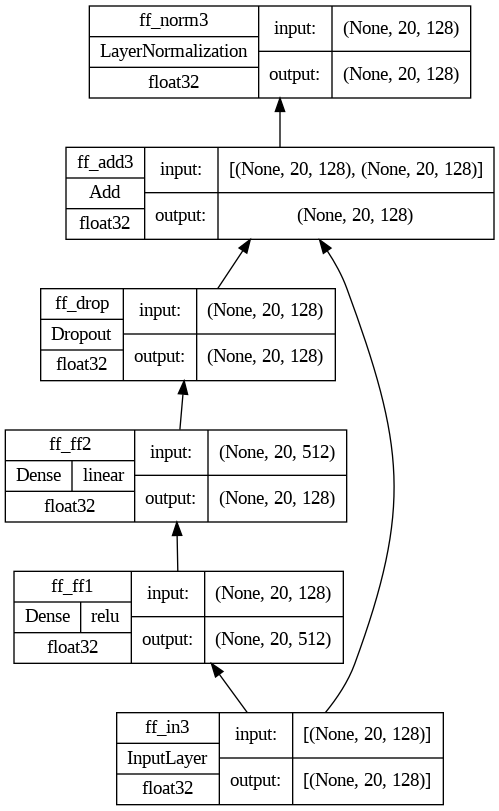

In [18]:
import tensorflow as tf

def feed_forward(input_shape, model_dim, ff_dim, dropout=0.1, prefix="ff"):
    """Feed-forward layers at transformer encoder and decoder. Assumes its
    input is the output from an attention layer with add & norm, the output
    is the output of one encoder or decoder block

    Args:
        model_dim (int): Output dimension of the feed-forward layer, which
                         is also the output dimension of the encoder/decoder
                         block
        ff_dim (int): Internal dimension of the feed-forward layer
        dropout (float): Dropout rate
        prefix (str): The prefix added to the layer names
    """
    # create layers
    inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32',
                                   name=f"{prefix}_in3")
    dense1 = tf.keras.layers.Dense(ff_dim, name=f"{prefix}_ff1", activation="relu")
    dense2 = tf.keras.layers.Dense(model_dim, name=f"{prefix}_ff2")
    drop = tf.keras.layers.Dropout(dropout, name=f"{prefix}_drop")
    add = tf.keras.layers.Add(name=f"{prefix}_add3")
    # functional API to connect input to output
    ffout = drop(dense2(dense1(inputs)))
    norm = tf.keras.layers.LayerNormalization(name=f"{prefix}_norm3")
    outputs = norm(add([inputs, ffout]))
    # create model and return
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name=f"{prefix}_ff")
    return model

seq_length = 20
key_dim = 128
ff_dim = 512

model = feed_forward(input_shape=(seq_length, key_dim),
                     model_dim=key_dim, ff_dim=ff_dim)
tf.keras.utils.plot_model(model, "feedforward.png",
                          show_shapes=True, show_dtype=True, show_layer_names=True,
                          rankdir='BT', show_layer_activations=True)

The model plotted would look like the following. Note that the first Dense layer uses ReLU activation and the second has no activation. A dropout layer is then appended for regularization.

## 7. Transformer Encoder and Decoder

Look again at the diagram of the transformer in Lesson 05. You will see that the encoder is the self-attention submodel connected to the feed-forward submodel. The decoder, on the other hand, is a self-attention submodel, a cross-attention submodel, and a feed-forward submodel connected in tandem.

Making an encoder and a decoder is therefore not difficult once you have these submodels as building blocks. Firstly, you have the encoder. It is simple enough that you can build an encoder model using Keras sequential API.

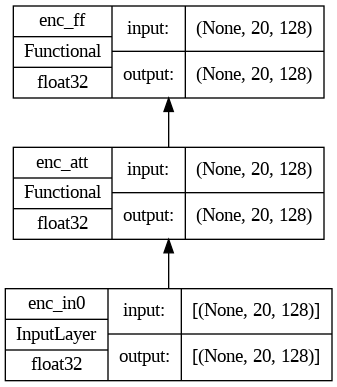

In [19]:
import tensorflow as tf
 
# the building block functions from Lesson 06
# from lesson_06 import self_attention, feed_forward
 
def encoder(input_shape, key_dim, ff_dim, dropout=0.1, prefix="enc", **kwargs):
    """One encoder unit. The input and output are in the same shape so we can
    daisy chain multiple encoder units into one larger encoder"""
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=input_shape, dtype='float32', name=f"{prefix}_in0"),
        self_attention(input_shape, prefix=prefix, key_dim=key_dim, mask=False, **kwargs),
        feed_forward(input_shape, key_dim, ff_dim, dropout, prefix),
    ], name=prefix)
    return model
 
 
seq_length = 20
key_dim = 128
ff_dim = 512
num_heads = 8
 
model = encoder(input_shape=(seq_length, key_dim), key_dim=key_dim, ff_dim=ff_dim,
                num_heads=num_heads)
tf.keras.utils.plot_model(model, "encoder.png",
                          show_shapes=True, show_dtype=True, show_layer_names=True,
                          rankdir='BT', show_layer_activations=True)


The decoder is a bit complicated because the cross-attention block takes input from the encoder as well; hence it is a model that takes two input. It is implemented as follows:

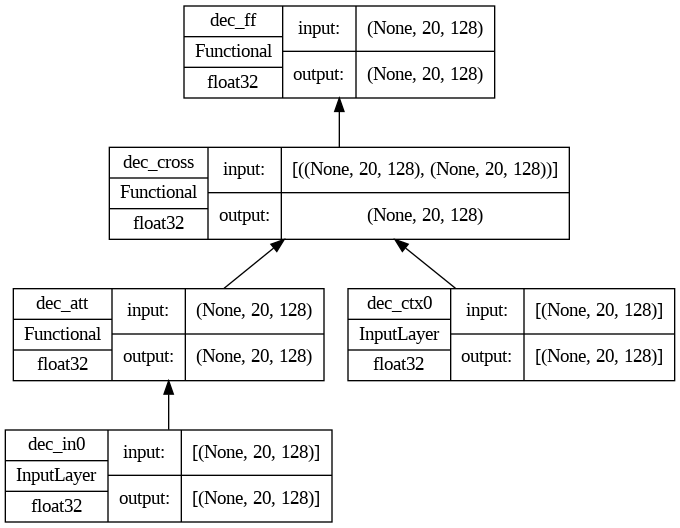

In [20]:
import tensorflow as tf
 
# the three building block functions from Lesson 06
# from lesson_06 import self_attention, cross_attention, feed_forward
 
def decoder(input_shape, key_dim, ff_dim, dropout=0.1, prefix="dec", **kwargs):
    """One decoder unit. The input and output are in the same shape so we can
    daisy chain multiple decoder units into one larger decoder. The context
    vector is also assumed to be the same shape for convenience"""
    inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32',
                                   name=f"{prefix}_in0")
    context = tf.keras.layers.Input(shape=input_shape, dtype='float32',
                                    name=f"{prefix}_ctx0")
    attmodel = self_attention(input_shape, key_dim=key_dim, mask=True,
                              prefix=prefix, **kwargs)
    crossmodel = cross_attention(input_shape, input_shape, key_dim=key_dim,
                                 prefix=prefix, **kwargs)
    ffmodel = feed_forward(input_shape, key_dim, ff_dim, dropout, prefix)
    x = attmodel(inputs)
    x = crossmodel([(context, x)])
    output = ffmodel(x)
    model = tf.keras.Model(inputs=[(inputs, context)], outputs=output, name=prefix)
    return model
 
 
seq_length = 20
key_dim = 128
ff_dim = 512
num_heads = 8
 
model = decoder(input_shape=(seq_length, key_dim), key_dim=key_dim, ff_dim=ff_dim,
                num_heads=num_heads)
tf.keras.utils.plot_model(model, "decoder.png",
                          show_shapes=True, show_dtype=True, show_layer_names=True,
                          rankdir='BT', show_layer_activations=True)

## 8. Building a Transformer

Indeed, a transformer has encoder and decoder parts, and each part is not one but a series of encoders or decoders. It sounds complicated but not if you have the building block submodels to hide the details.

Refer to the figure in Lesson 05, and you see the encoder and decoder parts are just a chain of encoder and decoder blocks. Only the output of the final encoder block is used as input to the decoder blocks.

Therefore, the complete transformer model can be built as follows:

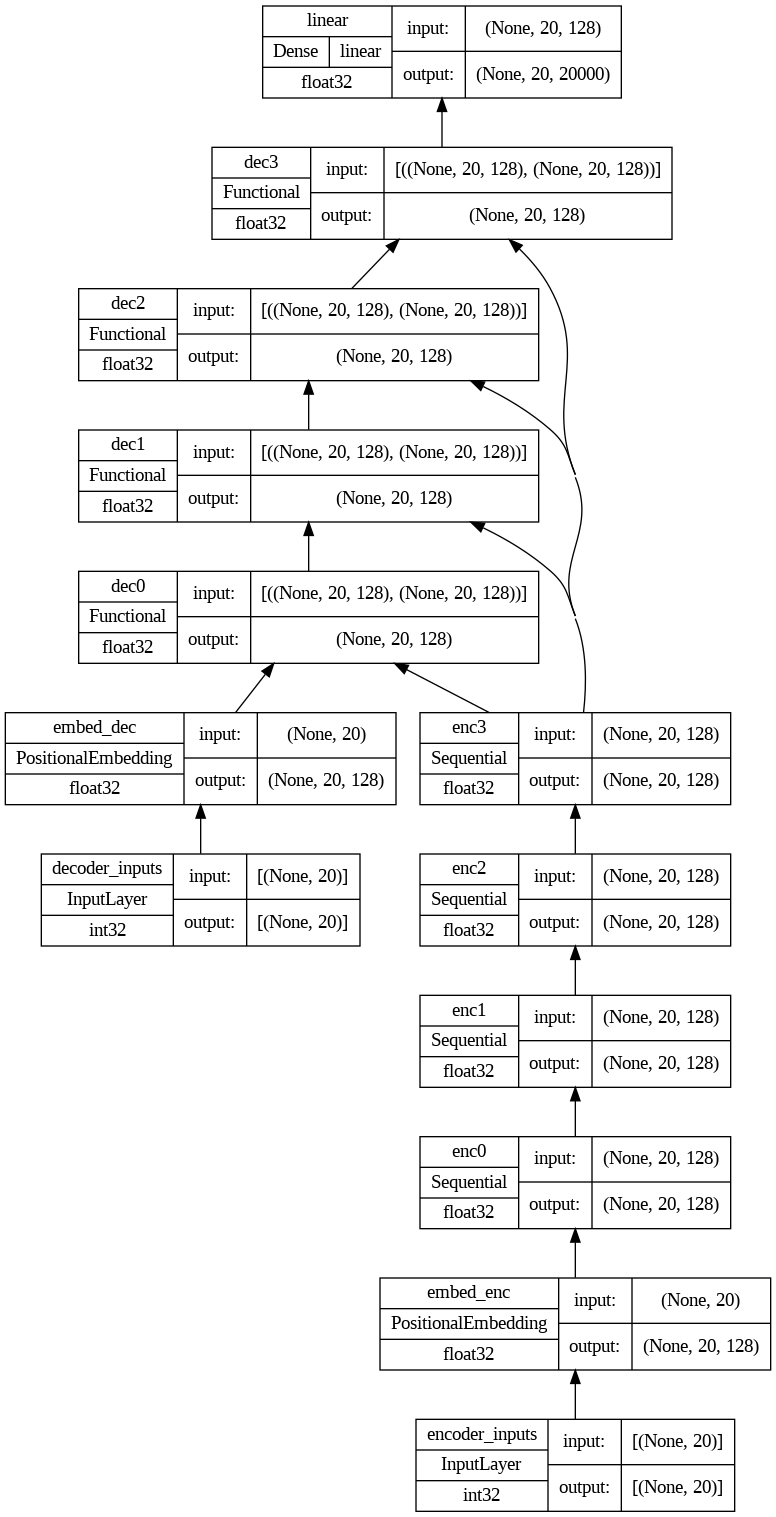

In [21]:
import tensorflow as tf
 
# the positional embedding layer from Lesson 05
# from lesson_05 import PositionalEmbedding
# the building block functions from Lesson 07
# from lesson_07 import encoder, decoder
 
 
def transformer(num_layers, num_heads, seq_len, key_dim, ff_dim, vocab_size_src,
                vocab_size_tgt, dropout=0.1, name="transformer"):
    embed_shape = (seq_len, key_dim)  # output shape of the positional embedding layer
    # set up layers
    input_enc = tf.keras.layers.Input(shape=(seq_len,), dtype="int32",
                                      name="encoder_inputs")
    input_dec = tf.keras.layers.Input(shape=(seq_len,), dtype="int32",
                                      name="decoder_inputs")
    embed_enc = PositionalEmbedding(seq_len, vocab_size_src, key_dim, name="embed_enc")
    embed_dec = PositionalEmbedding(seq_len, vocab_size_tgt, key_dim, name="embed_dec")
    encoders = [encoder(input_shape=embed_shape, key_dim=key_dim,
                        ff_dim=ff_dim, dropout=dropout, prefix=f"enc{i}",
                        num_heads=num_heads)
                for i in range(num_layers)]
    decoders = [decoder(input_shape=embed_shape, key_dim=key_dim,
                        ff_dim=ff_dim, dropout=dropout, prefix=f"dec{i}",
                        num_heads=num_heads)
                for i in range(num_layers)]
    final = tf.keras.layers.Dense(vocab_size_tgt, name="linear")
    # build output
    x1 = embed_enc(input_enc)
    x2 = embed_dec(input_dec)
    for layer in encoders:
        x1 = layer(x1)
    for layer in decoders:
        x2 = layer([x2, x1])
    output = final(x2)
    # XXX keep this try-except block
    try:
        del output._keras_mask
    except AttributeError:
        pass
    model = tf.keras.Model(inputs=[input_enc, input_dec], outputs=output, name=name)
    return model
 
 
seq_len = 20
num_layers = 4
num_heads = 8
key_dim = 128
ff_dim = 512
dropout = 0.1
vocab_size_en = 10000
vocab_size_fr = 20000
model = transformer(num_layers, num_heads, seq_len, key_dim, ff_dim,
                    vocab_size_en, vocab_size_fr, dropout)
tf.keras.utils.plot_model(model, "transformer.png",
                          show_shapes=True, show_dtype=True, show_layer_names=True,
                          rankdir='BT', show_layer_activations=True)

The try–except block in the code is to handle a bug in certain versions of TensorFlow that may cause the training error calculated erroneously. The model plotted above would be like the following. Not very simple, but the architecture is still tractable.

## 9. Prepare the Transformer Model for Training

Before you can train your transformer, you need to decide how you should train it.

According to the paper Attention Is All You Need, you are using Adam as the optimizer but with a custom learning rate schedule,

 
 
 

It is implemented as follows:

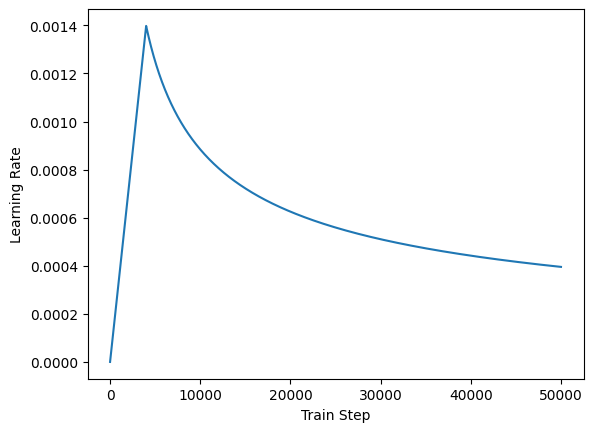

In [22]:

import matplotlib.pyplot as plt
import tensorflow as tf
 
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    "Custom learning rate for Adam optimizer"
    def __init__(self, key_dim, warmup_steps=4000):
        super().__init__()
        self.key_dim = key_dim
        self.warmup_steps = warmup_steps
        self.d = tf.cast(self.key_dim, tf.float32)
 
    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d) * tf.math.minimum(arg1, arg2)
 
    def get_config(self):
        # to make save and load a model using custom layer possible0
        config = {
            "key_dim": self.key_dim,
            "warmup_steps": self.warmup_steps,
        }
        return config
 
key_dim = 128
lr = CustomSchedule(key_dim)
optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
 
plt.plot(lr(tf.range(50000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')
plt.show()

Next, you also need to define the loss metric and accuracy metric for training. This model is special because you need to apply a mask to the output to calculate the loss and accuracy only on the non-padding elements. Borrow the implementation from TensorFlow’s tutorial Neural machine translation with a Transformer and Keras (https://www.tensorflow.org/text/tutorials/transformer):

In [23]:
def masked_loss(label, pred):
    mask = label != 0
 
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_object(label, pred)
 
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss
 
def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred
 
    mask = label != 0
 
    match = match & mask
 
    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

With all these, you can now compile your Keras model as follows:

In [24]:
vocab_size_en = 10000
vocab_size_fr = 20000
seq_len = 20
num_layers = 4
num_heads = 8
key_dim = 128
ff_dim = 512
dropout = 0.1
model = transformer(num_layers, num_heads, seq_len, key_dim, ff_dim,
                    vocab_size_en, vocab_size_fr, dropout)
lr = CustomSchedule(key_dim)
optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
model.compile(loss=masked_loss, optimizer=optimizer, metrics=[masked_accuracy])
model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 20)]         0           []                               
                                                                                                  
 embed_enc (PositionalEmbedding  (None, 20, 128)     1280000     ['encoder_inputs[0][0]']         
 )                                                                                                
                                                                                                  
 enc0 (Sequential)              (None, 20, 128)      659712      ['embed_enc[0][0]']              
                                                                                                  
 enc1 (Sequential)              (None, 20, 128)      659712      ['enc0[0][0]']         

## 10. Training the Transformer

Epoch 1/3
1828/1828 [==============================] - 257s 120ms/step - loss: 5.1989 - masked_accuracy: 0.3068 - val_loss: 3.1673 - val_masked_accuracy: 0.4685
Epoch 2/3
1828/1828 [==============================] - 183s 100ms/step - loss: 2.6982 - masked_accuracy: 0.5460 - val_loss: 2.2390 - val_masked_accuracy: 0.6045
Epoch 3/3
1828/1828 [==============================] - 182s 99ms/step - loss: 2.0944 - masked_accuracy: 0.6319 - val_loss: 1.8189 - val_masked_accuracy: 0.6693


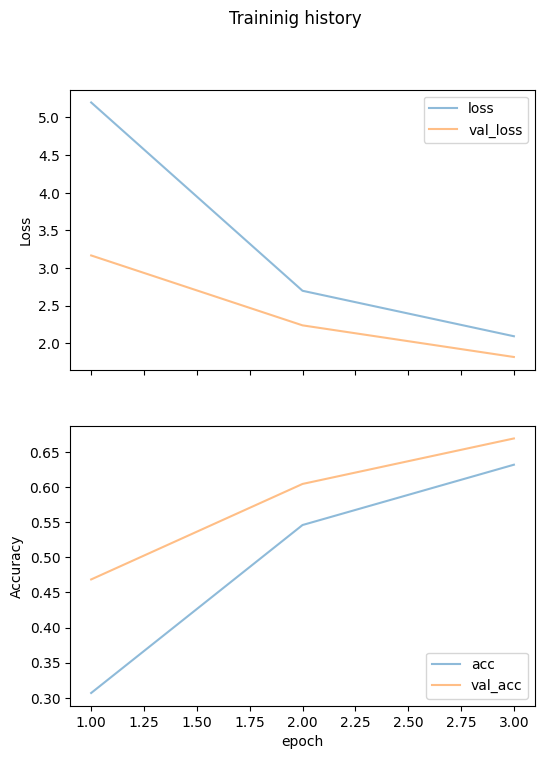

In [25]:
import matplotlib.pyplot as plt
import tensorflow as tf
 
# # the dataset objects from Lesson 03
# from lesson_03 import train_ds, val_ds
# # the building block functions from Lesson 08
# from lesson_08 import transformer
# # the learning rate schedule, loss, and accuracy functions from Lesson 09
# from lesson_09 import CustomSchedule, masked_loss, masked_accuracy
 
 
# Create and train the model
seq_len = 20
num_layers = 4
num_heads = 8
key_dim = 128
ff_dim = 512
dropout = 0.1
vocab_size_en = 10000
vocab_size_fr = 20000
model = transformer(num_layers, num_heads, seq_len, key_dim, ff_dim,
                    vocab_size_en, vocab_size_fr, dropout)
lr = CustomSchedule(key_dim)
optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
model.compile(loss=masked_loss, optimizer=optimizer, metrics=[masked_accuracy])
epochs = 3
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)
 
# Save the trained model
model.save("eng-fra-transformer.h5")
 
# Plot the loss and accuracy history
fig, axs = plt.subplots(2, figsize=(6, 8), sharex=True)
fig.suptitle('Traininig history')
x = list(range(1, epochs+1))
axs[0].plot(x, history.history["loss"], alpha=0.5, label="loss")
axs[0].plot(x, history.history["val_loss"], alpha=0.5, label="val_loss")
axs[0].set_ylabel("Loss")
axs[0].legend(loc="upper right")
axs[1].plot(x, history.history["masked_accuracy"], alpha=0.5, label="acc")
axs[1].plot(x, history.history["val_masked_accuracy"], alpha=0.5, label="val_acc")
axs[1].set_ylabel("Accuracy")
axs[1].set_xlabel("epoch")
axs[1].legend(loc="lower right")
plt.show()

## 11. Inference from the Transformer Model

In Lesson 03, you split the original dataset into training, validation, and test sets in the ratio of 70%-15%-15%. You used the training and validation dataset in the training of the transformer model in Lesson 10. And in this lesson, you are going to use the test set to see how good your trained model is.

You saved your transformer model in the previous lesson. Because you have some custom made layers and functions in the model, you need to create a custom object scope to load your saved model.

The transformer model can give you a token index. You need the vectorizer to look up the word that this index represents. You have to reuse the same vectorizer that you used in creating the dataset to maintain consistency.

Create a loop to scan the generated tokens. In other words, do not use the model to generate the entire translated sentence but consider only the next generated word in the sentence until you see the end sentinel. The first generated word would be the one generated by the start sentinel. It is the reason you processed the target sentences this way in Lesson 02.

The code is as follows:

In [26]:
import pickle
import random
random.seed(SEED)
 
import numpy as np
import tensorflow as tf
 
# # the dataset objects from Lesson 03
# from lesson_03 import test_pairs, eng_vectorizer, fra_vectorizer
# # the positional embedding layer from Lesson 05
# from lesson_05 import PositionalEmbedding
# # the learning rate schedule, loss, and accuracy functions from Lesson 09
# from lesson_09 import CustomSchedule, masked_loss, masked_accuracy
 
 
# Load the trained model
custom_objects = {"PositionalEmbedding": PositionalEmbedding,
                  "CustomSchedule": CustomSchedule,
                  "masked_loss": masked_loss,
                  "masked_accuracy": masked_accuracy}
with tf.keras.utils.custom_object_scope(custom_objects):
    model = tf.keras.models.load_model("eng-fra-transformer.h5")
 
# training parameters used
seq_len = 20
vocab_size_en = 10000
vocab_size_fr = 20000
 
def translate(sentence):
    """Create the translated sentence"""
    enc_tokens = eng_vectorizer([sentence])
    lookup = list(fra_vectorizer.get_vocabulary())
    start_sentinel, end_sentinel = "[start]", "[end]"
    output_sentence = [start_sentinel]
    # generate the translated sentence word by word
    for i in range(seq_len):
        vector = fra_vectorizer([" ".join(output_sentence)])
        assert vector.shape == (1, seq_len+1)
        dec_tokens = vector[:, :-1]
        assert dec_tokens.shape == (1, seq_len)
        pred = model([enc_tokens, dec_tokens])
        assert pred.shape == (1, seq_len, vocab_size_fr)
        word = lookup[np.argmax(pred[0, i, :])]
        output_sentence.append(word)
        if word == end_sentinel:
            break
    return output_sentence
 
test_count = 20
for n in range(test_count):
    english_sentence, french_sentence = random.choice(test_pairs)
    translated = translate(english_sentence)
    print(f"Test {n}:")
    print(f"{english_sentence}")
    print(f"== {french_sentence}")
    print(f"-> {' '.join(translated)}")
    print()

Test 0:
i'm sorry that you didn't sleep well .
== [start] je suis désolé que tu n'aies pas bien dormi . [end]
-> [start] je suis désolée que tu ne t'es pas bien dormi . [end]

Test 1:
i don't plan on losing .
== [start] je ne prévois pas de perdre . [end]
-> [start] je ne prévois pas de perdre . [end]

Test 2:
we're all at risk .
== [start] nous sommes toutes en danger . [end]
-> [start] nous sommes tous en danger . [end]

Test 3:
he admitted that it was true .
== [start] il a admis que c'était vrai . [end]
-> [start] il a couru comme ça était vraie . [end]

Test 4:
pay what you want .
== [start] paie ce que tu veux . [end]
-> [start] prenez ce que tu veux . [end]

Test 5:
this invention will make you very rich .
== [start] cette invention te rendra très riche . [end]
-> [start] cette imagination vous fera beaucoup près . [end]

Test 6:
your parents are expecting your call .
== [start] tes parents attendent ton appel . [end]
-> [start] tes parents sont en train de ton professeur . [end

## Dependencies

In [27]:
!pip install session-info

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 KB 7.2 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8042 sha256=f49cbcd5c21cf1bd7fcf797e2fd441207e8fe0c6f6dbaa2abaaf0419d14eff19
  Stored in directory: /root/.cache/pip/wheels/d4/fc/2e/00ca60bac7954b84907efd41baa9b4853500eaeec4228410c6
Successfully built session-info


In [28]:
import session_info

session_info.show()